In [ ]:
# Gerekli kütüphaneleri yükleyin
import os
import shutil
import glob
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import warnings
import tensorflow as tf

# Uyarıları gizle
warnings.filterwarnings("ignore")

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Keras ve TensorFlow
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

#open-cv
import cv2


In [ ]:
# Eğitim ve Doğrulama Görüntüleri için Yollar
train_path ='C:/Users/esraa/Desktop/base_dir/train_dir'
valid_path ='C:/Users/esraa/Desktop/base_dir/val_dir'

In [40]:
#dosya listelenmesi
def getListOfFiles(dirName):
    listOfFile = os.listdir(dirName)
    allFiles = list()
    for entry in listOfFile:
        fullPath = os.path.join(dirName, entry)
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
    return allFiles

In [41]:
#Görüntü İşleme Fonksiyonu
def image_to_feature_vector(image, size=(224, 224)):
    return cv2.resize(image, size).flatten()

In [42]:
# ### GPU'nun uygunluğunu kontrol etme
# from keras import backend as K
# K.tensorflow_backend._get_available_gpus()

In [43]:
def get_files(directory):
    if not os.path.exists(directory):
        return 0
    count = 0
    for current_path, dirs, files in os.walk(directory):
        for dr in dirs:
            count += len(glob.glob(os.path.join(current_path, dr + "/*")))
    return count

In [ ]:
# Girdi görüntüsünün yükseklik, genişlik ve renk ayarı.
IMG_CHANNELS = 3
IMG_ROWS = 224
IMG_COLS = 224
input_shape = (IMG_ROWS, IMG_COLS ,3)

# ### Eğitim ve Doğrulama Örnek Sayıları
train_samples_num = get_files(train_path)
val_samples_num = get_files(valid_path)
print(train_samples_num)
print(val_samples_num)

# Model eğitim ayarları
epochs = 20
train_batch_size = 64
val_batch_size = 64
image_size = 224


# Bir iterasyonda kaç adım gerektiğini bildirme
train_steps = train_samples_num // train_batch_size
val_steps = val_samples_num // val_batch_size



16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
efficientnet_model = EfficientNetB0(input_shape=input_shape, weights='imagenet', include_top=False)
efficientnet_model.trainable = False

# Modeli düzenleme
x = efficientnet_model.output
x = tf.keras.layers.Rescaling(1./255)(x)  # Use tf.keras.layers.Rescaling instead
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x)

# Yeni çıktılı bir model oluşturma
model = tf.keras.Model(inputs=efficientnet_model.input, outputs=predictions)

# Modeldeki yeni katmanların özetine bakma
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 6,152,362 (23.47 MB)

 Trainable params: 2,102,791 (8.02 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_batches = data_gen.flow_from_directory(train_path,
                                             target_size=(image_size, image_size),
                                             batch_size=train_batch_size,
                                             color_mode='rgb',
                                             class_mode='categorical'
                                             )

valid_batches = data_gen.flow_from_directory(valid_path,
                                             target_size=(image_size, image_size),
                                             batch_size=val_batch_size,
                                             color_mode='rgb',
                                             class_mode='categorical'
                                             )

test_batches = data_gen.flow_from_directory(valid_path,
                                            target_size=(image_size, image_size),
                                            batch_size=val_batch_size,
                                            shuffle=False,
                                            color_mode='rgb',
                                            class_mode='categorical'
                                            )


Found 4962 images belonging to 7 classes.
Found 552 images belonging to 7 classes.
Found 552 images belonging to 7 classes.


In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])


# Modeli save etmek için checkpoint bildirimi
filepath = "C:/Users/esraa/Desktop/base_dir/efficientnet_model.keras"

checkpoint = ModelCheckpoint(filepath,
                             monitor='loss',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='min')

reduce_lr = ReduceLROnPlateau(monitor='loss',
                              factor=0.5,
                              patience=2,
                              verbose=1,
                              mode='min',
                              min_lr=0.00001)

callbacks_list = [checkpoint, reduce_lr]


In [49]:
# Modeli eğitme
history = model.fit(train_batches,
                    steps_per_epoch=train_steps,
                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=epochs,
                    verbose=1,
                    callbacks=callbacks_list)


Epoch 1/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7593 - loss: 1.4945
Epoch 1: loss improved from inf to 1.10280, saving model to G:/My Drive/SKIN-LESION-CLASSIFIER/efficientnet_model.keras
155/155 ━━━━━━━━━━━━━━━━━━━━ 545s 3s/step - accuracy: 0.7596 - loss: 1.4920 - val_accuracy: 0.8015 - val_loss: 0.7621 - learning_rate: 1.0000e-04
Epoch 2/30
  1/155 ━━━━━━━━━━━━━━━━━━━━ 5:43 2s/step - accuracy: 0.7812 - loss: 0.8298
Epoch 2: loss improved from 1.10280 to 0.82980, saving model to G:/My Drive/SKIN-LESION-CLASSIFIER/efficientnet_model.keras
155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7812 - loss: 0.8298 - val_accuracy: 0.7500 - val_loss: 0.9751 - learning_rate: 1.0000e-04
Epoch 3/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8033 - loss: 0.7420
Epoch 3: loss improved from 0.82980 to 0.73086, saving model to G:/My Drive/SKIN-LESION-CLASSIFIER/efficientnet_model.keras
155/155 ━━━━━━━━━━━━━━━━━━━━ 498s 3s/step - accuracy: 0.8033 - loss: 0.7419 - val_a

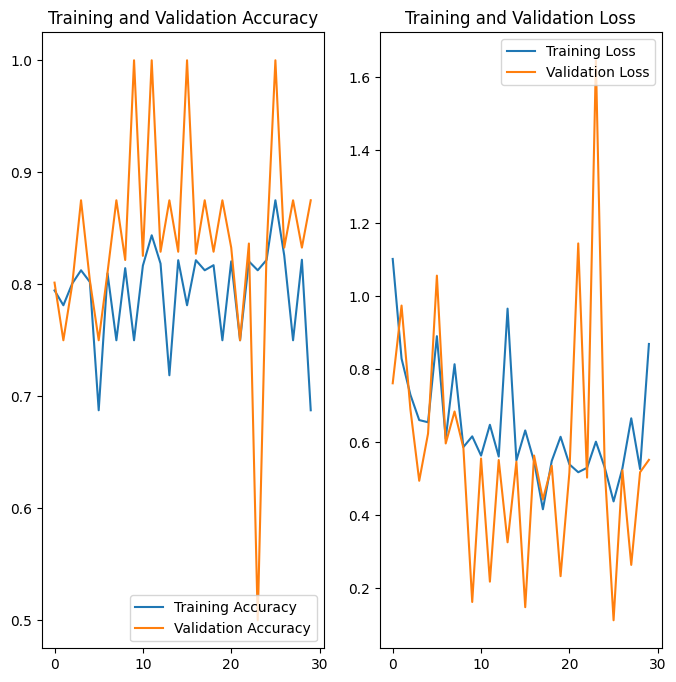

In [56]:
# Eğitim sonuçlarını görselleştirme
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [57]:
# Model ağırlıklarını yükleme
model.load_weights(filepath)

# Modeli değerlendirme
val_loss, val_acc = model.evaluate(test_batches, steps=val_steps)
print('val_loss:', val_loss)
print('val_cat_acc:', val_acc)


17/17 ━━━━━━━━━━━━━━━━━━━━ 66s 4s/step - accuracy: 0.6184 - loss: 1.0682
val_loss: 0.49476712942123413
val_cat_acc: 0.8400735259056091


In [ ]:
# Modeli hesaplama
# Son dönümün hesabı
val_loss, val_cat_acc = model.evaluate(test_batches, steps=val_steps)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)


# En iyi dönüm için hesaplama
model.load_weights(filepath)

val_loss, val_cat_acc = model.evaluate(test_batches, steps=val_steps)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)

# Test görüntülerinin confusion matrisini oluşturma
test_labels = test_batches.classes

# Tahmin yapma
predictions = model.predict(test_batches, verbose=1)

In [ ]:
# Confusion matrisi oluşturma
cm = confusion_matrix(test_labels, predicted_classes)
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

# Confusion matrisini görselleştirme
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cm_plot_labels)
disp.plot()
plt.show()

18/18 ━━━━━━━━━━━━━━━━━━━━ 68s 4s/step
Normalized Confusion Matrix
[[0.         0.         0.73333333 0.         0.         0.26666667
  0.        ]
 [0.         0.         0.5        0.         0.         0.5
  0.        ]
 [0.         0.         0.52272727 0.         0.         0.47727273
  0.        ]
 [0.         0.         0.         0.         0.         1.
  0.        ]
 [0.         0.         0.34782609 0.         0.         0.65217391
  0.        ]
 [0.         0.         0.01357466 0.         0.         0.98642534
  0.        ]
 [0.         0.         0.         0.         0.         1.
  0.        ]]


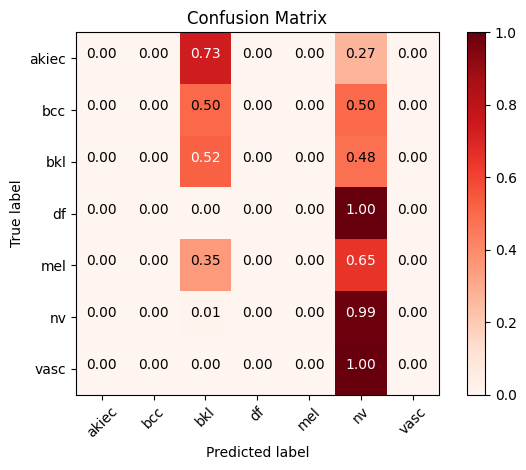

In [58]:

# Test görüntülerinin confusion matrisini oluşturma
test_labels = test_batches.classes


# Tahmin yapma
predictions = model.predict(test_batches, test_batches.n//test_batches.batch_size+1, verbose=1)
predictions = np.argmax(predictions, axis=1)


# Confusion matrisi fonksiyonu
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion Matrix', cmap=plt.cm.Reds):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(test_labels, predictions)
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
plot_confusion_matrix(cm, cm_plot_labels)
plt.show()

image shape: (224, 224, 3)


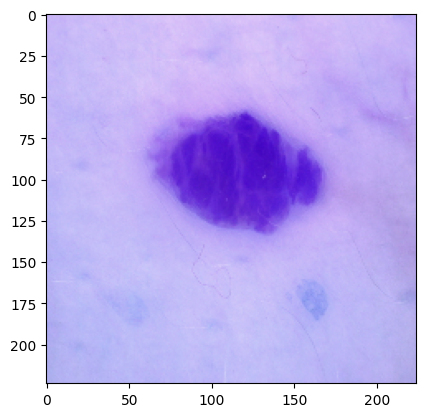

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
[[0.00367483 0.00521786 0.02068366 0.00648677 0.01471749 0.93736553
  0.01185385]]
nv


In [ ]:
img_test = cv2.imread(valid_path+'/vasc/ISIC_0026876.jpg')
# Resizing image
img_scaled = cv2.resize(img_test,(image_size,image_size))
img_test = tf.image.convert_image_dtype(img_scaled, dtype=tf.float32,
                                        saturate=False)
print("image shape: {}".format(img_test.shape))
plt.imshow(img_test)
plt.show()
#img_test = img_test/255.

img_test = np.expand_dims(img_test, axis=0)
# getting model predictions
test_predictions = model.predict(img_test)
print(test_predictions)
predicted_label = np.argmax(test_predictions)

print(cm_plot_labels[predicted_label])

In [ ]:
import tensorflow as tf

# .keras modelini yükleme
model = tf.keras.models.load_model("C:/Users/esraa/Desktop/base_dir/efficientnet_model.keras")

# Modeli .h5 formatında kaydetme
model.save("C:/Users/esraa/Desktop/base_dir/efficientnet_model.h5")